## <span style="color:green"> Notebook - Mapping metasomatised domains from MT Models</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In [1]:
import os
from pathlib import Path
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import pide
from pide.mt.mt_model_read import read_ModEM_rho
from pide.utils.utils import read_csv, associate_coordinates
from pide.utils.gis_tools import lat_lon_to_utm, get_utm_zone_number

notebook_path = Path().resolve()

In [3]:
wus_rho_path = os.path.join(notebook_path,'..','example_data','WUS_MT_Model','WUS.MT.Bedrosian2021.resistivity.rho')

#model centers for georeferencing
mc_lat = 40.75
mc_lon = -113.25

utm_no = get_utm_zone_number(mc_lon)
mc_x, mc_y = lat_lon_to_utm(mc_lat,mc_lon)

#reading the MT model file
rho, mesh_x, mesh_y, mesh_z = read_ModEM_rho(rho_file_path=wus_rho_path)

#converting x and y to utm coordinates
x = mesh_x
y = mesh_y

#Getting the vertical indexes of 
idx_96 = (np.abs((mesh_z/1e3) - 96.0)).argmin()
idx_155 = (np.abs((mesh_z/1e3) - 155.0)).argmin()

#Getting the resistivities at 50 and 100 km
rho_96 = rho[idx_96].flatten()
rho_155 = rho[idx_155].flatten()

cond_96 = 1.0/rho_96
cond_155 = 1.0/rho_155

/home/sinan/src/SEL/pide/utils/gis_tools.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  utm_x, utm_y = transform(wgs84, utm, longitude, latitude)


[1.250000e+01 3.900000e+01 6.800000e+01 9.950000e+01 1.345000e+02
 1.730000e+02 2.150000e+02 2.615000e+02 3.130000e+02 3.695000e+02
 4.315000e+02 4.995000e+02 5.740000e+02 6.560000e+02 7.465000e+02
 8.460000e+02 9.555000e+02 1.076000e+03 1.208500e+03 1.354500e+03
 1.515000e+03 1.691500e+03 1.886000e+03 2.100000e+03 2.335000e+03
 2.593500e+03 2.878000e+03 3.191000e+03 3.535500e+03 3.914500e+03
 4.331000e+03 4.789000e+03 5.293000e+03 5.847500e+03 6.457500e+03
 7.128500e+03 7.866500e+03 8.678000e+03 9.570500e+03 1.055250e+04
 1.163250e+04 1.282050e+04 1.412750e+04 1.556500e+04 1.714650e+04
 1.888600e+04 2.079900e+04 2.290350e+04 2.521850e+04 2.776500e+04
 3.056650e+04 3.364800e+04 3.703750e+04 4.076600e+04 4.486750e+04
 4.937900e+04 5.434150e+04 5.980050e+04 6.580550e+04 7.241100e+04
 7.967700e+04 8.766950e+04 9.646150e+04 1.061330e+05 1.167715e+05
 1.284735e+05 1.413455e+05 1.555050e+05 1.710805e+05 1.882135e+05
 2.070600e+05 2.277910e+05 2.505950e+05 2.756795e+05 3.032725e+05
 3.336245e

In [3]:
#Reading the temperature model
T_path = os.path.join(notebook_path,'..','example_data','WUS_MT_Model','WinterCGTemp_Cropped_WUS.lis')
data_T = read_csv(filename=T_path, delim = ' ')
data_T = np.array(data_T[1:], dtype = float) #Skipping header  with 1:

data_T_depth = data_T[:,3]
data_T_temp = data_T[:,4] + 273.15 #converting from C to K
data_T_lat = data_T[:,2]
data_T_lon = data_T[:,1] - 360.0 #Converting it to negative before Greenwich.

#Getting all indices of latitude and longitude by using a single depth.
data_T_lat = data_T_lat[np.where(data_T_depth==-49.0)[0]]
data_T_lon = data_T_lon[np.where(data_T_depth==-49.0)[0]]

x_T, y_T = lat_lon_to_utm(latitude = data_T_lat, longitude = data_T_lon, zone_number = utm_no)

x_T = x_T - mc_x
y_T = y_T - mc_y


T_96 = data_T_temp[np.where(data_T_depth==-97.0)[0]]
T_155 = data_T_temp[np.where(data_T_depth==-155.0)[0]]

#We want to make these calculations at 50 and 100 km. So only loading the T at those temperatures.

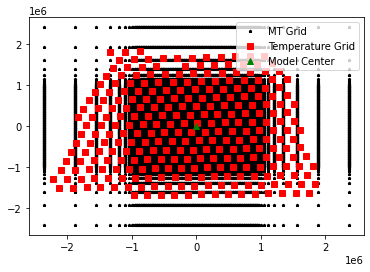

In [4]:
plt.plot(x,y,'*', color = 'k', markersize = 3, label = 'MT Grid')
plt.plot(x_T,y_T, 's', color = 'r',label = 'Temperature Grid')
plt.plot(0,0, '^', color = 'g', label = 'Model Center')
plt.legend()
plt.show()

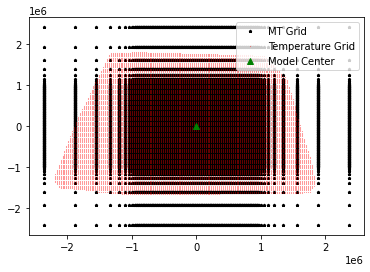

In [5]:
#2D interpolation of Temperature field to make 

x_new = np.arange(np.amin(x_T),np.amax(x_T),30e3) #every 5_000 m
y_new = np.arange(np.amin(y_T),np.amax(y_T),30e3) #every 5_000 m

coords_mesh = np.meshgrid(x_new, y_new)

points_interp = np.column_stack((x_T, y_T))


T_96_interp = griddata(points_interp, T_96, (coords_mesh[0], coords_mesh[1]), method = 'cubic')
T_155_interp = griddata(points_interp, T_155, (coords_mesh[0], coords_mesh[1]), method = 'cubic')


T_96_interp = T_96_interp.flatten()
T_155_interp = T_155_interp.flatten()
coords_x = coords_mesh[0].flatten()
coords_y = coords_mesh[1].flatten()

#Applying mask for nan values at T due to interpolation out of bounds
mask = np.isnan(T_49_interp)
T_49_i = T_49_interp[~mask]
T_155_i = T_155_interp[~mask]
coords_x = coords_x[~mask]
coords_y = coords_y[~mask]

plt.plot(x,y,'*', color = 'k', markersize = 3, label = 'MT Grid')
plt.plot(coords_x,coords_y, 's', color = 'r',label = 'Temperature Grid', markersize = 0.1)
plt.plot(0,0, '^', color = 'g', label = 'Model Center')
plt.legend()
plt.show()



In [6]:
##associateding coordinates for with

idx_ = associate_coordinates(sample_x = coords_x, sample_y = coords_y, target_x=x, target_y=y, num_cpu = 5)

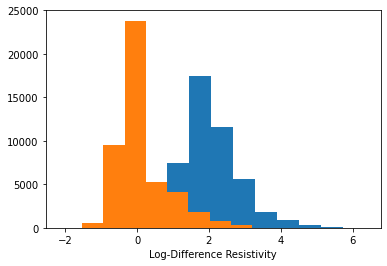

In [7]:
p_obj = pide.pide()
p_obj.set_temperature(T_96_i[idx_])
p_obj.set_pressure(96.0 / 33.0) #pressure roughly calculated.
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.25,cpx = 0.1, garnet= 0.05)
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound




p_obj = pide.pide()
p_obj.set_temperature(T_155_i[idx_])
p_obj.set_pressure(155.0 / 33.0) #pressure roughly calculated.
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3,cpx = 0.1)
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

cond_s_49 = p_obj.calculate_conductivity()





In [8]:
xi = np.arange(np.amin(x), np.amax(x),1000)
yi = np.arange(np.amin(y), np.amax(y),1000)

x_i,  y_i = np.meshgrid(xi,yi)

points_interp = np.column_stack((x, y))

real_model_49 = griddata(points_interp, logmodel_49, (x_i, y_i), method = 'cubic')
synth_model_49 = griddata(points_interp, logsynthetic_49, (x_i, y_i), method = 'cubic')
diff_log_49 = synth_model_49 - real_model_49

real_model_96 = griddata(points_interp, logmodel_96, (x_i, y_i), method = 'cubic')
synth_model_96 = griddata(points_interp, logsynthetic_96, (x_i, y_i), method = 'cubic')
diff_log_96 = synth_model_96 - real_model_96

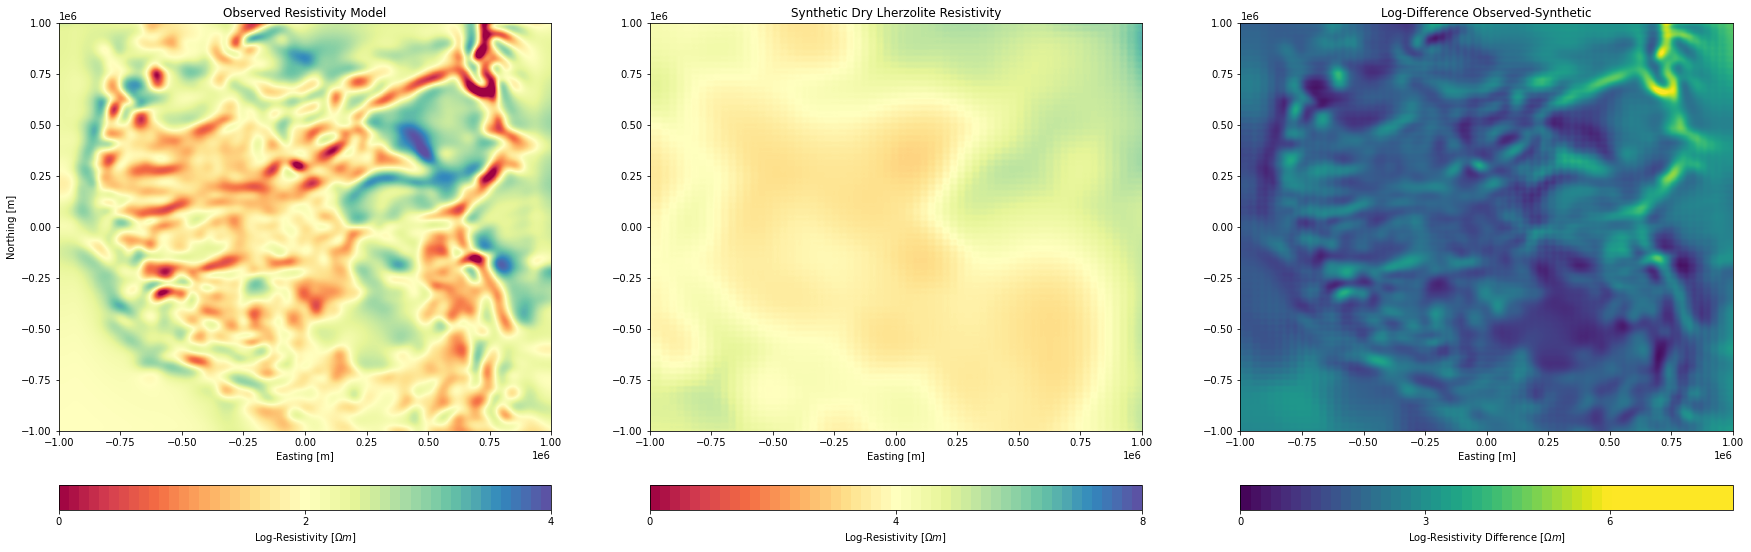

In [9]:
fig = plt.figure(figsize = (30,10))
ax1 = plt.subplot(131)
cax1 = ax1.pcolormesh(xi,yi, real_model_49, cmap = 'Spectral')
cax1.set_clim(0,4)
cbar_ax = fig.colorbar(cax1, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax1, label = 'Log-Resistivity [$\Omega m$]')

ax1.set_xlim(-1e6,1e6)
ax1.set_ylim(-1e6,1e6)
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_title('Observed Resistivity Model')

ax2 = plt.subplot(132)
cax2 = ax2.pcolormesh(xi,yi, synth_model_49, cmap = 'Spectral')
cax2.set_clim(0,8)
cbar_ax2 = fig.colorbar(cax2, boundaries= np.linspace(0,8), orientation="horizontal", pad=0.1,
			 ticks = [0,4,8], ax = ax2, label = 'Log-Resistivity [$\Omega m$]')

ax2.set_xlim(-1e6,1e6)
ax2.set_ylim(-1e6,1e6)
ax2.set_xlabel('Easting [m]')
ax2.set_title('Synthetic Dry Lherzolite Resistivity')

ax3 = plt.subplot(133)
cax3 = ax3.pcolormesh(xi,yi, diff_log_49, cmap = 'viridis')
cax3.set_clim(0,6)
cbar_ax3 = fig.colorbar(cax3, boundaries= np.linspace(0,8), orientation="horizontal", pad=0.1,
			 ticks = [0,3,6], ax = ax3, label = 'Log-Resistivity Difference [$\Omega m$]')

ax3.set_xlim(-1e6,1e6)
ax3.set_ylim(-1e6,1e6)
ax3.set_xlabel('Easting [m]')
ax3.set_title('Log-Difference Observed-Synthetic')


plt.show()

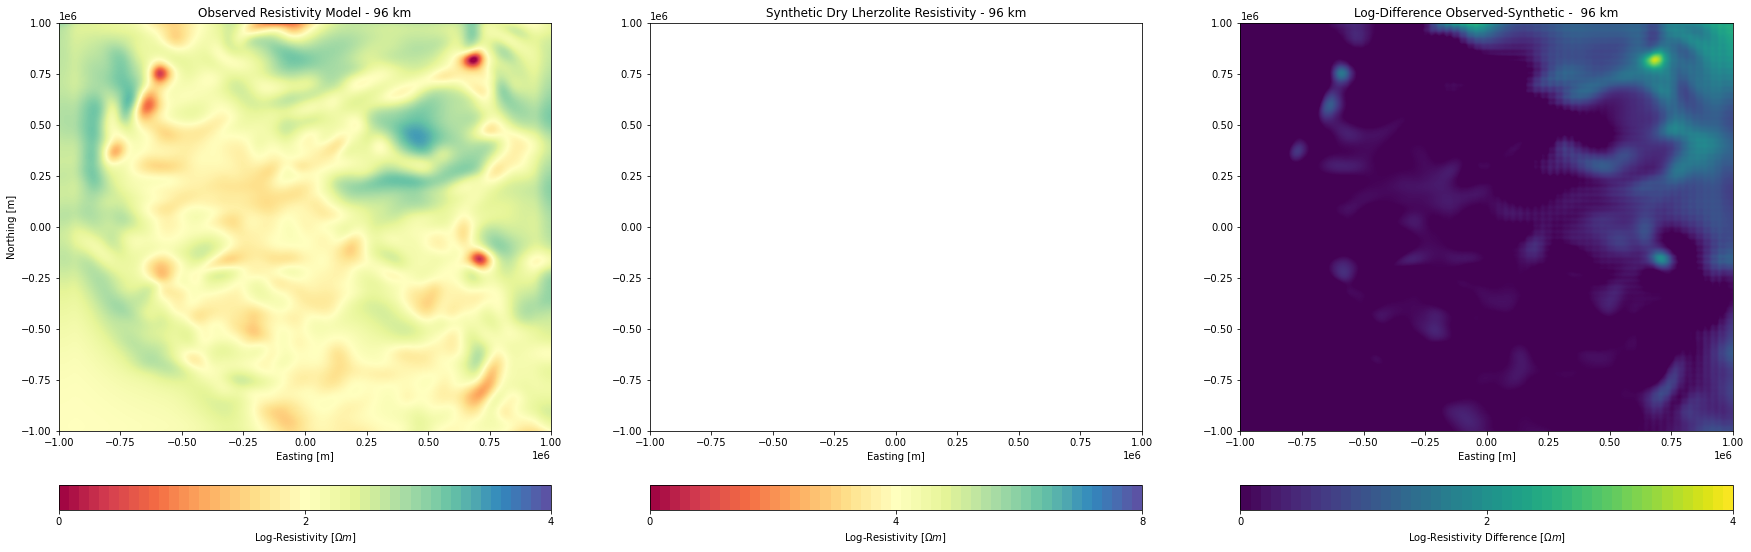

In [10]:
fig = plt.figure(figsize = (30,10))
ax4 = plt.subplot(131)
cax4 = ax4.pcolormesh(xi,yi, real_model_96, cmap = 'Spectral')
cax4.set_clim(0,4)
cbar_ax = fig.colorbar(cax4, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax4, label = 'Log-Resistivity [$\Omega m$]')

ax4.set_xlim(-1e6,1e6)
ax4.set_ylim(-1e6,1e6)
ax4.set_xlabel('Easting [m]')
ax4.set_ylabel('Northing [m]')
ax4.set_title('Observed Resistivity Model - 96 km')

ax5 = plt.subplot(132)
cax5 = ax2.pcolormesh(xi,yi, synth_model_96, cmap = 'Spectral')
cax5.set_clim(0,8)
cbar_ax2 = fig.colorbar(cax5, boundaries= np.linspace(0,8), orientation="horizontal", pad=0.1,
			 ticks = [0,4,8], ax = ax5, label = 'Log-Resistivity [$\Omega m$]')

ax5.set_xlim(-1e6,1e6)
ax5.set_ylim(-1e6,1e6)
ax5.set_xlabel('Easting [m]')
ax5.set_title('Synthetic Dry Lherzolite Resistivity - 96 km')

ax6 = plt.subplot(133)
cax6 = ax6.pcolormesh(xi,yi, diff_log_96, cmap = 'viridis')
cax6.set_clim(0,4)
cbar_ax6 = fig.colorbar(cax6, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax6, label = 'Log-Resistivity Difference [$\Omega m$]')

ax6.set_xlim(-1e6,1e6)
ax6.set_ylim(-1e6,1e6)
ax6.set_xlabel('Easting [m]')
ax6.set_title('Log-Difference Observed-Synthetic -  96 km')

plt.show()